
compare different model versions

for flexibelNoise, plot sd(x)

In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd
import arviz as az


bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk')

from utils import get_data  
df = get_data(bids_folder)
df = df.xs(format,0, level='format')

number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


KeyError: <built-in function format>

In [14]:
format = 'symbolic'
model_1 =  az.from_netcdf(op.join(target_folder, f'model-2_format-{format}_trace.netcdf'))
model_2 =  az.from_netcdf(op.join(target_folder, f'model-5_format-{format}_trace.netcdf'))

In [13]:
# compute likelihood 
from utils_02 import build_model
from utils import get_data  
import pymc as pm

df = get_data(bids_folder)
df = df.xs(format,0, level='format')

for model_label in ['5']:

    model = build_model(model_label, df)
    model.build_estimation_model()

    trace = az.from_netcdf(op.join(target_folder, f'model-{model_label}_format-{format}_trace_.netcdf'))

    with model.estimation_model:
        pm.compute_log_likelihood(trace)
        
    az.to_netcdf(trace,op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')
{'evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'prior_mu': {'mu_intercept': 23.2989104501352, 'sigma_intercept': 25.0, 'transform': 'identity'}, 'prior_sd': {'mu_intercept': 23.298

/Users/mrenke/git/bauer/bauer/models.py:1496: UserWarning: Found evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


In [15]:
compare_dict = {"2 priors": model_1, #"n1/n2, fit prior": model_2,
                "flexibelNoise": model_2}

az.compare(compare_dict)

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
2 priors,0,-4375.368674,176.410236,0.000000,0.898273,61.719813,0.000000,True,log
flexibelNoise,1,-4685.717279,255.479048,310.348605,0.101727,65.351013,30.597213,True,log


## flexibel Noise

In [2]:
import pandas as pd
import numpy as np

def get_pars(trace, model,par = ''):
    n_polynomials = 5

    intercept_pars = pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('Intercept', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)
    group_pars =  pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('group', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)

    control = intercept_pars
    dyscalculic = intercept_pars + group_pars

    x = np.linspace(5, 90)
    
    dm = model.make_dm(x, variable=f'{par}evidence_sd')
    evidence_sd_c = pd.DataFrame(dm.dot(control.T),
                                        index=pd.Index(x, name='x'),
                                        columns=control.index).stack([0, 1]).to_frame('sd')

    evidence_sd_d = pd.DataFrame(dm.dot(dyscalculic.T),
                                            index=pd.Index(x, name='x'),
                                            columns=dyscalculic.index).stack([0, 1]).to_frame('sd')

    evidence_sd = pd.concat([evidence_sd_c, evidence_sd_d], keys=['control', 'dyscalculic'], names=['group'], axis=0)

    return evidence_sd #control, dyscalculic

import arviz as az
def get_hdi(d):
    return pd.Series(az.hdi(d.values, hdi_prob=0.95), index=['hdi025', 'hdi975'])


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


{'evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'prior_mu': {'mu_intercept': 23.31279129984464, 'sigma_intercept': 25.0, 'transform': 'identity'}, 'prior_sd': {'mu_intercept': 23.31279129984464, 'sigma_intercept': 25.0, 'transform': 'softplus'}}
{'evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline4': {'mu_intercept': 

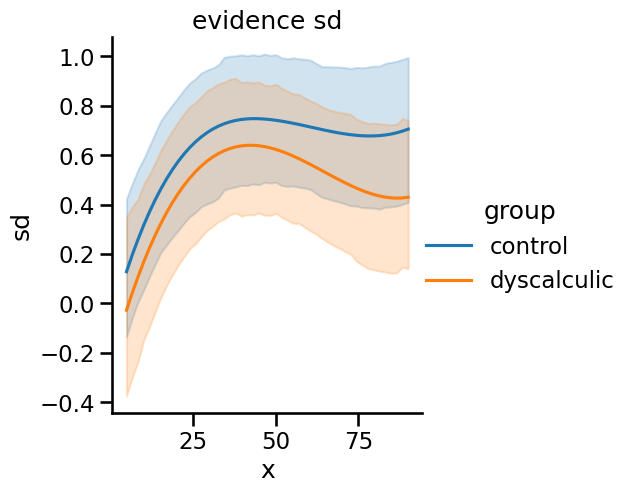

In [3]:
import seaborn as sns
from utils_02 import build_model

sns.set_context('talk')

model_label = '5'
format = 'symbolic'
model = build_model(model_label, df)
model.build_estimation_model()
trace = az.from_netcdf(op.join(target_folder, f'model-5_format-{format}_trace.netcdf'))

evidence_sd = get_pars(trace,model)
g = sns.relplot(data=evidence_sd.reset_index(), x='x', y='sd', hue='group', kind='line', errorbar=get_hdi)
g.set(title=f'evidence sd')

but prior also tighter ! 

In [4]:
import seaborn as sns
from utils_02 import build_model

sns.set_context('talk')

model_label = '9reg'
format = 'symbolic'
model = build_model(model_label, df)
model.build_estimation_model()
trace = az.from_netcdf(op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))

/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found n1_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')
/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found n2_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


{'n1_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'risky_prior_mu': {

[(0.0, 1.5)]

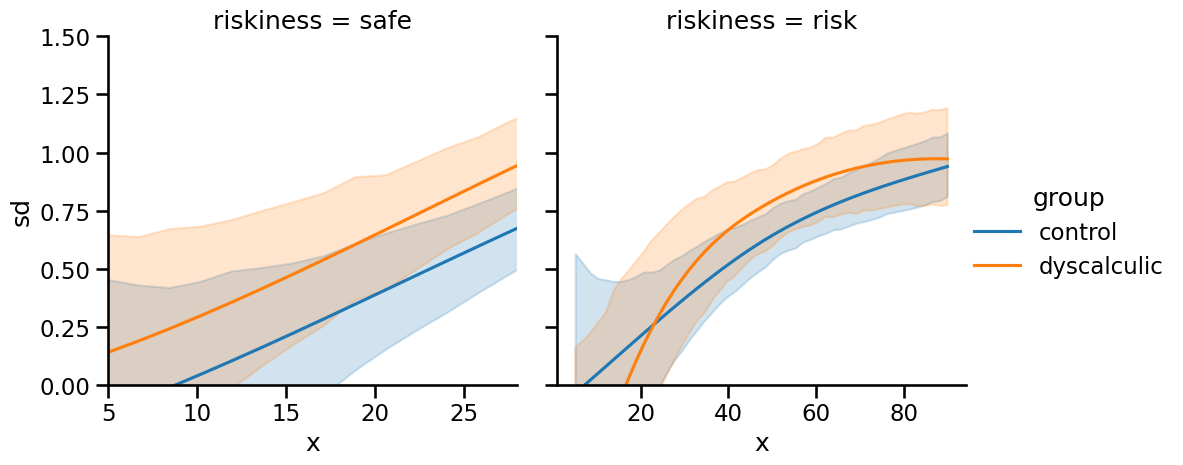

In [5]:
safe_evidence_sd = get_pars(trace,model,par='n1_')
risk_evidence_sd = get_pars(trace,model,par='n2_')

evidence_sd = pd.concat([safe_evidence_sd, risk_evidence_sd], keys=['safe', 'risk'], names=['riskiness'], axis=0)

g = sns.relplot(data=evidence_sd.reset_index(), x='x', y='sd', hue='group', col='riskiness', kind='line', errorbar=get_hdi, facet_kws={'sharex': False})
g.axes[0,0].set(xlim=[5,28],ylim=[0,1])
g.axes[0,1].set(ylim=[0,1.5])

[(5.0, 28.0), (-0.5, 0.5)]

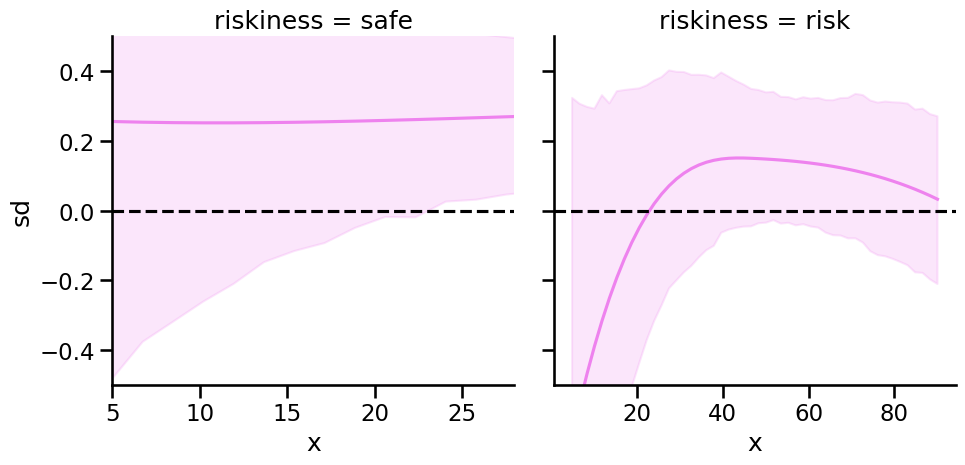

In [22]:
import matplotlib.pyplot as plt
evidence_sd_diff = evidence_sd.xs('dyscalculic',0,level='group') - evidence_sd.xs('control',0,level='group')

g = sns.relplot(data=evidence_sd_diff.reset_index(), x='x', y='sd', col='riskiness', kind='line', errorbar=get_hdi, facet_kws={'sharex': False}, color='violet')
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
g.axes[0,0].set(xlim=[5,28],ylim=[-0.5,0.5])
